# Lab2. Amazon SageMaker Random Cut Forest

In this notebook we will build Anomaly detection model for timeseries dataset. We will use Random Cut Forest algorithm provided by SageMaker to detect anomalies in the clickstream dataset.

Amazon SageMaker is a fully managed machine learning service. Amazon SageMaker provides several built-in machine learning algorithms that you can use for a variety of problem types. There are dozens of built-in algorithms like [Linear learner algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html), the [XGBoost Algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) as well as [Random Cut Forest](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html) (RCF). We use the RCF that is an unsupervised algorithm to detect anomalous data points within a data set. 

## Table Of Contents
1. Data Preparation
2. Creating the RCF Model
3. Detecting spikes with the Model
4. Plotting the Prediction
5. Stop and delete the endpoint

## 1. Data Preparation

Let's look at the dataset first. We will use fake dataset that fascimile real clickstream data in `data` folder. 

In [1]:
# This notebook code was tested with SageMaker SDK 2.20
# !pip install -U sagemaker==2.20

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import boto3
import botocore
import sagemaker
import sys
from sagemaker import RandomCutForest

from util import *

Unzip the compressed file and look at the dataset.

In [3]:
data_dir='data'
!tar -zxvf $data_dir/data.tar.gz --directory=data

data/
data/fault_label_1T.csv
data/clicks_1T.csv
data/clicks.csv
data/.ipynb_checkpoints/
data/clicks_10T.csv
data/fault_label_10T.csv


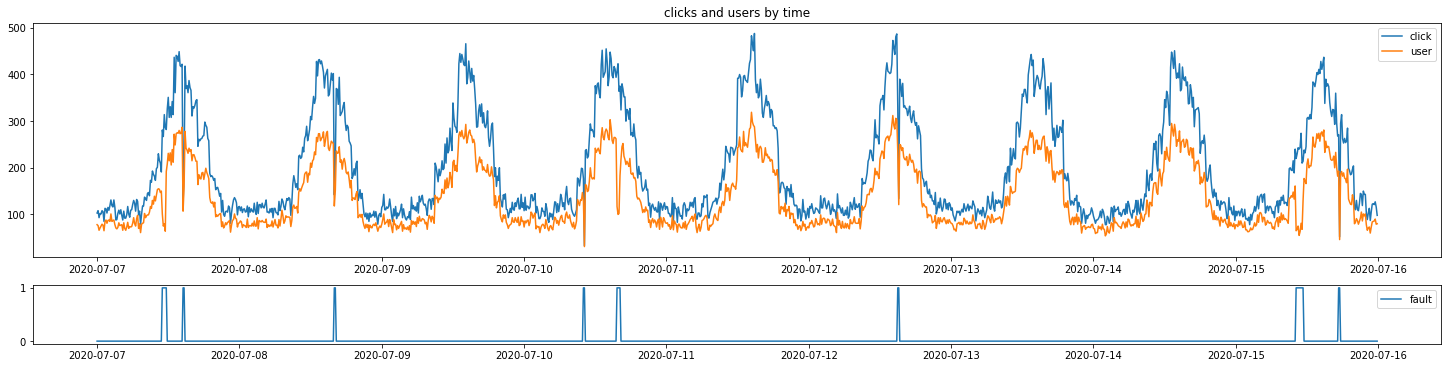

In [4]:
clicks_10T = pd.read_csv(data_dir + '/clicks_10T.csv', parse_dates=['timestamp']).set_index('timestamp')
clicks_10T['fault'] = pd.read_csv(data_dir + '/fault_label_10T.csv', header=None).values[0]

plot_click_w_fault(clicks_10T)

When dealing with multivariate timeseries dataset, adding the residuals is a very useful and frequently used technique. In this scenario, the difference between the total number of clicks and the number of users is the important factor for detecting a failure. We will use this as a feature for our model.

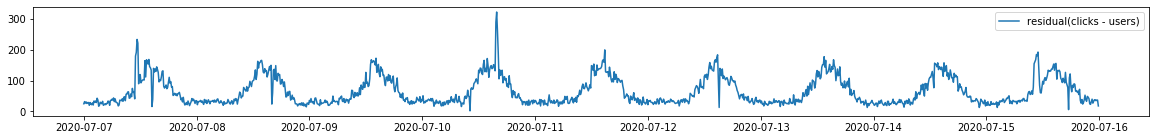

In [5]:
clicks_10T['residual'] = clicks_10T['click'] - clicks_10T['user']

plt.figure(figsize=(20,2))
plt.plot(clicks_10T['residual'])
plt.legend(['residual(clicks - users)'])
plt.show()

In [6]:
train = clicks_10T[['user','click','residual']][:-144]
test = clicks_10T[['user','click','residual']][-144:]

In [7]:
train.head()

,user,click,residual
timestamp,,,
2020-07-07 00:00:00,78,103,25
2020-07-07 00:10:00,76,108,32
2020-07-07 00:20:00,66,93,27
2020-07-07 00:30:00,71,102,31
2020-07-07 00:40:00,75,101,26


## 2. Creating the RCF Model

We train the model with SageMaker built-in RandomCutForest algorithm. 

This algorithm takes a bunch of random data points (Random), cuts them to the same number of points and creates trees (Cut). It then looks at all of the trees together (Forest) to determine whether a particular data point is an anomaly. A tree is a great way to store data because it’s easy and fast for a computer to use. To create a tree, you randomly subdivide the data points until you isolate the point you’re testing to determine whether it’s an anomaly. Each time you subdivide the data points, it creates a new level of the tree. The fewer times you need to subdivide the data points before you isolate the target data point the more likely it is that the data point is an anomaly for that sample of data.

You can find more deteiled information from [here](https://docs.aws.amazon.com/sagemaker/latest/dg/rcf_how-it-works.html).

### Training job

Define RandomCutorest and set the hyperparameters for RCF training:

* **num_samples_per_tree** - the number randomly sampled data points sent to each tree. As a general rule, **1/num_samples_per_tree** should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **num_trees** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **feature_dim** - the dimension of each data point.

In addition to these RCF model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: ml.m4, ml.c4, or ml.c5
* Current limitations:
    * The RCF algorithm does not take advantage of GPU hardware.

In [ ]:
session = sagemaker.Session()
execution_role = sagemaker.get_execution_role()

bucket = session.default_bucket()
prefix = 'rcf-clickstream'

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=100)

rcf.fit(rcf.record_set(train.to_numpy(),
                       channel='train', encrypt=False))

## 3. Detecting spikes with the Model  

After you train your model, you can deploy it to get predictions. We can detect unexpected spikes on the website by fetching anomaly socres from this endpoint.

In [9]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----------------!

Below code will invoke the endpoint train data. Before looking at the anomaly score for our test data, we need to decide a thresold to determin whether it is abnomarl or not. To do that, we will look at the distribution of inference results(anomaly scores). Plotting a histogram is often useful when deciding the threshold of anomaly scores. 

When invoking endpoint, we configured endpoint with SageMaker Python SDK's csv_serializer and json_deserializer. We can pass data in a variety of formats to the endpoint. In this example we will use CSV-formatted data and pass it as numpy array. Other available formats are JSON-formatted and RecordIO Protobuf.

3 sigma threshold : 3.1105467749364344


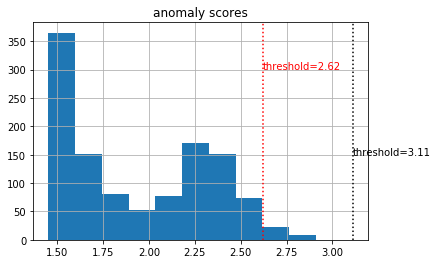

In [19]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# set the serializer and deserializer of the endpoint and then call an inference.
rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

# invoke endpoint
results = rcf_inference.predict(train.to_numpy())

results_pd = pd.DataFrame(results['scores'])
threshold = results_pd.mean() + results_pd.std()*3
print('3 sigma threshold : {}'.format(threshold.values[0]))

results_pd.hist()
plt.title('anomaly scores')
plt.axvline(x=2.62, linestyle=':', color='r')
plt.annotate('threshold=2.62', xy=(2.62,300), color='r')
plt.axvline(x=threshold.values, linestyle=':', color='k')
plt.annotate('threshold={}'.format(round(threshold.values[0],2)), xy=(threshold,150))
plt.show()

Since RCF is an unsupervised algorithm, label data is not required. However, if you have even some of labeled data to distingish whether they are normal or not, you can use them to decide the thresold by **choosing the number to prduce the highest precision, recall, or F1 score**. This also means this labeled data can be used for performance metrics for our model. If you pass the test dataset into the training job as a test channel, SageMaker will return this score. (Test data channel is optional)

If you do not have labeled data, you can choose **3 standard deviations** (approximately 99.9th percentile) as a rule of thumb (assuming the score is normaly distributed). Or, you can use an appropriate value by visually checking changes of the graph or the distribution of the histogram. 

From our result, 3 standard deviations value is around 3.1. However, we will choose 2.6 as our custom threshold to see if our model can catch the program fault.

In [20]:
custom_threshold = 2.62

## 4. Plotting the Prediction

The code below will invoke the endpoint with test data and plot the results(anomalies). Anomalous points with scores above the threshold are marked with dots.

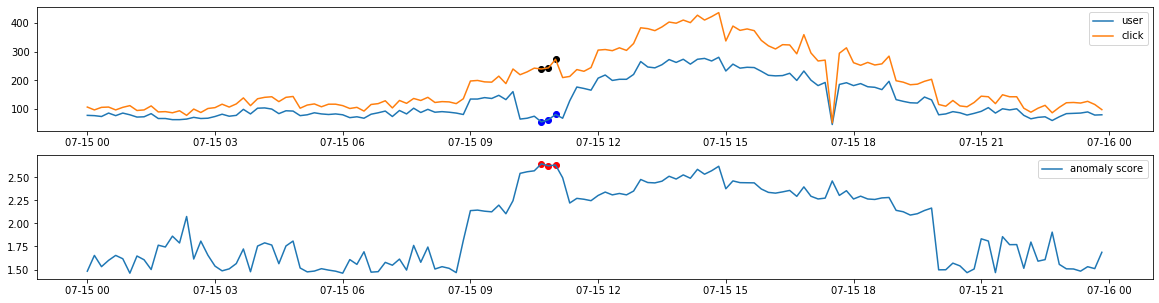

In [21]:
results_test = rcf_inference.predict(test.to_numpy())
results_test_pd = pd.DataFrame(results_test['scores'])
results_test_pd.set_index(test.index, inplace=True)

plt.figure(figsize=(20,5))
anomalous = test[list((results_test_pd > custom_threshold)['score'])]
anomalous['score'] = results_test_pd[list((results_test_pd > custom_threshold)['score'])].values

plt.subplot(2,1,1)
plt.plot(test[['user','click']])
# plt.scatter(x= anomalous.index, y=anomalous['page'].values, c='red')
plt.scatter(x= anomalous.index, y=anomalous['user'].values, c='blue')
plt.scatter(x= anomalous.index, y=anomalous['click'].values, c='black')
plt.legend(['user','click'])

plt.subplot(2,1,2)
plt.plot(results_test_pd)
plt.scatter(x= anomalous.index, y=anomalous['score'].values, c='red')
plt.legend(['anomaly score'])

plt.show()

Our model detected program faults well as it shows a big difference in the number of users and clicks. **(It didn't seem to detect system faults well but we will detect them in the next notebook.)** Please note that our model detected anomalies accroding to the changes and deviations in each feature value instead of using a fixed threshold.

## 5. Stop and Delete the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do this, execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable endpoint_name, and select "Delete" from the "Actions" dropdown menu.

In [22]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Next, move to [LAB3](3.DeepAR.ipynb) to see how to make use of time series prediction to detect anomalies